# Week 8 - Support Vector Machines
### Dr. David Elliott

1.1. [Introduction](#intro)

1.2. [Dataset Example](#data)

1.3. [What is a Hyperplane?](#hyperplane)

1.4. [Maximal Margin Classifier](#MMC)

**PLAN**
- Images from the Hands on machine learning (using the petal data)
- some explanation from the python ML
- structure of the Intro to stats learning & some algebra
- Some algebra from Machine learning: a probabilitistic perspective.

__TODO__
- look through https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%209.ipynb, and https://scikit-learn.org/stable/auto_examples/exercises/plot_iris_exercise.html#sphx-glr-auto-examples-exercises-plot-iris-exercise-py
- Tidy up the code... I dont need to worry about code blocks as much now as I don't need to show any code on a slide now!

# 1.1. Introduction <a id='intro'></a>

The term Support Vector Machines (SVM's) is sometimes used loosely to refer to three methods, each an extension of the previous method<sup>1</sup>:
- Maximal margin classifier,
- Support vector classifier,
- Support vector machine. 

SVM's are a common supervised discriminative algorithm, well suited to *complex* small- to medium sized datasets<sup>2</sup>

They can be used for both __classification__ and regression.

In [1]:
%matplotlib inline

import os # locating directories

import numpy as np   # Arrays
import pandas as pd  # DataFrames

# Plotting
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['animation.embed_limit'] = 30000000.0
plt.rcParams['figure.dpi'] = 300
import seaborn as sns; sns.set()

from sklearn.datasets import load_iris           # for the Iris data
from IPython.display import Image                # displaying .png images
from sklearn.svm import SVC, LinearSVC           # SVM
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding

# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
image_dir = os.path.join(os.getcwd(),"Images")

# displays the graph in the middle of the notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1.2. Dataset Example <a id='data'></a>

To demonstrate SVM's I'll be using Fisher's (or Anderson's) Iris flowers dataset<sup>3</sup>.

The dataset consists of 50 samples each from three species of Iris (Iris setosa, Iris virginica and Iris versicolor).

- _"...This data comes from a famous experiment on a series of measurements of three species of iris flowers. R A Fisher, a statistically minded thinker in the early twentieth centure used this dataset in his 1936 paper The Use of multiple measurements in taxonomic problems, published in the Annals of Eugenics."_ https://bookdown.org/koehlerj/qr_book/introducing-the-iris-dataset.html

- _"The Iris flower data set or Fisher's Iris data set is a multivariate data set introduced by the British statistician, eugenicist, and biologist Ronald Fisher in his 1936 paper The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis. It is sometimes called Anderson's Iris data set because Edgar Anderson collected the data to quantify the morphologic variation of Iris flowers of three related species."_ https://cloudxlab.com/assessment/displayslide/5165/keras-project-iris-flower-identification-introduction-to-iris-dataset

Figure 1: Iris Flowers


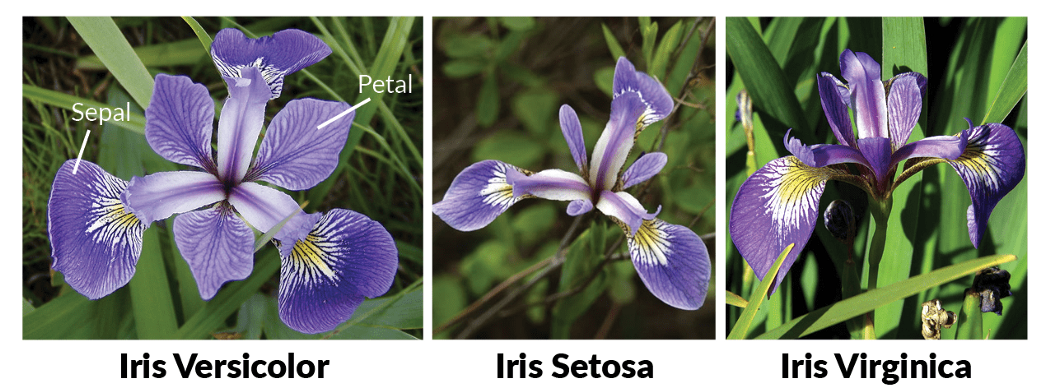

In [2]:
print("Figure 1: Iris Flowers")
# Image from: https://www.ritchieng.com/machine-learning-iris-dataset/
display(Image(os.path.join(image_dir,"iris_flowers.png")))

Five attributes were collected for the 150 records:
- sepal length (cm)
- sepal width (cm)
- petal length (cm)
- petal width (cm)
- species

In [3]:
iris = load_iris(as_frame=True)  # data stored in a `sklearn.utils.Bunch`
iris_df = iris['data']           # get features DataFrame
target = iris['target']          # get target Series
display(iris_df.head())             # display the first few rows

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Figure 2: Iris Attributes


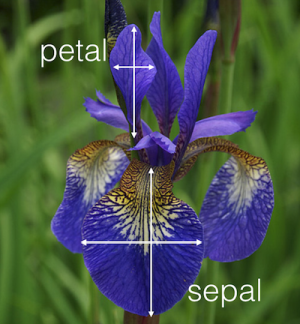

In [4]:
print("Figure 2: Iris Attributes")
# Image from: https://www.ritchieng.com/machine-learning-iris-dataset/
display(Image(os.path.join(image_dir,"iris_attributes.png")))

In [5]:
# get the labels of flowers capitalised for visualisation
target_names = list(map(lambda s: s.capitalize(), iris['target_names']))

# create a dictionary with the original labels decoded (inverse of LabelEncoder)
decode_label = dict(zip(range(3), target_names))

# make a label encoder to use later if needed
le = LabelEncoder().fit(target_names)
# display the labels
decode_label

{0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}

In [6]:
# add the target labels to df for visualisation purposes
iris_vis = pd.concat([iris_df, target],axis=1)
# turn the ints to labels
iris_vis["target"] = iris_vis["target"].replace(decode_label)
# Capitalize column names for plotting
iris_vis.columns = [x.capitalize() for x in list(iris_vis.columns)]
# display the first few rows
iris_vis.head()

,Sepal length (cm),Sepal width (cm),Petal length (cm),Petal width (cm),Target
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


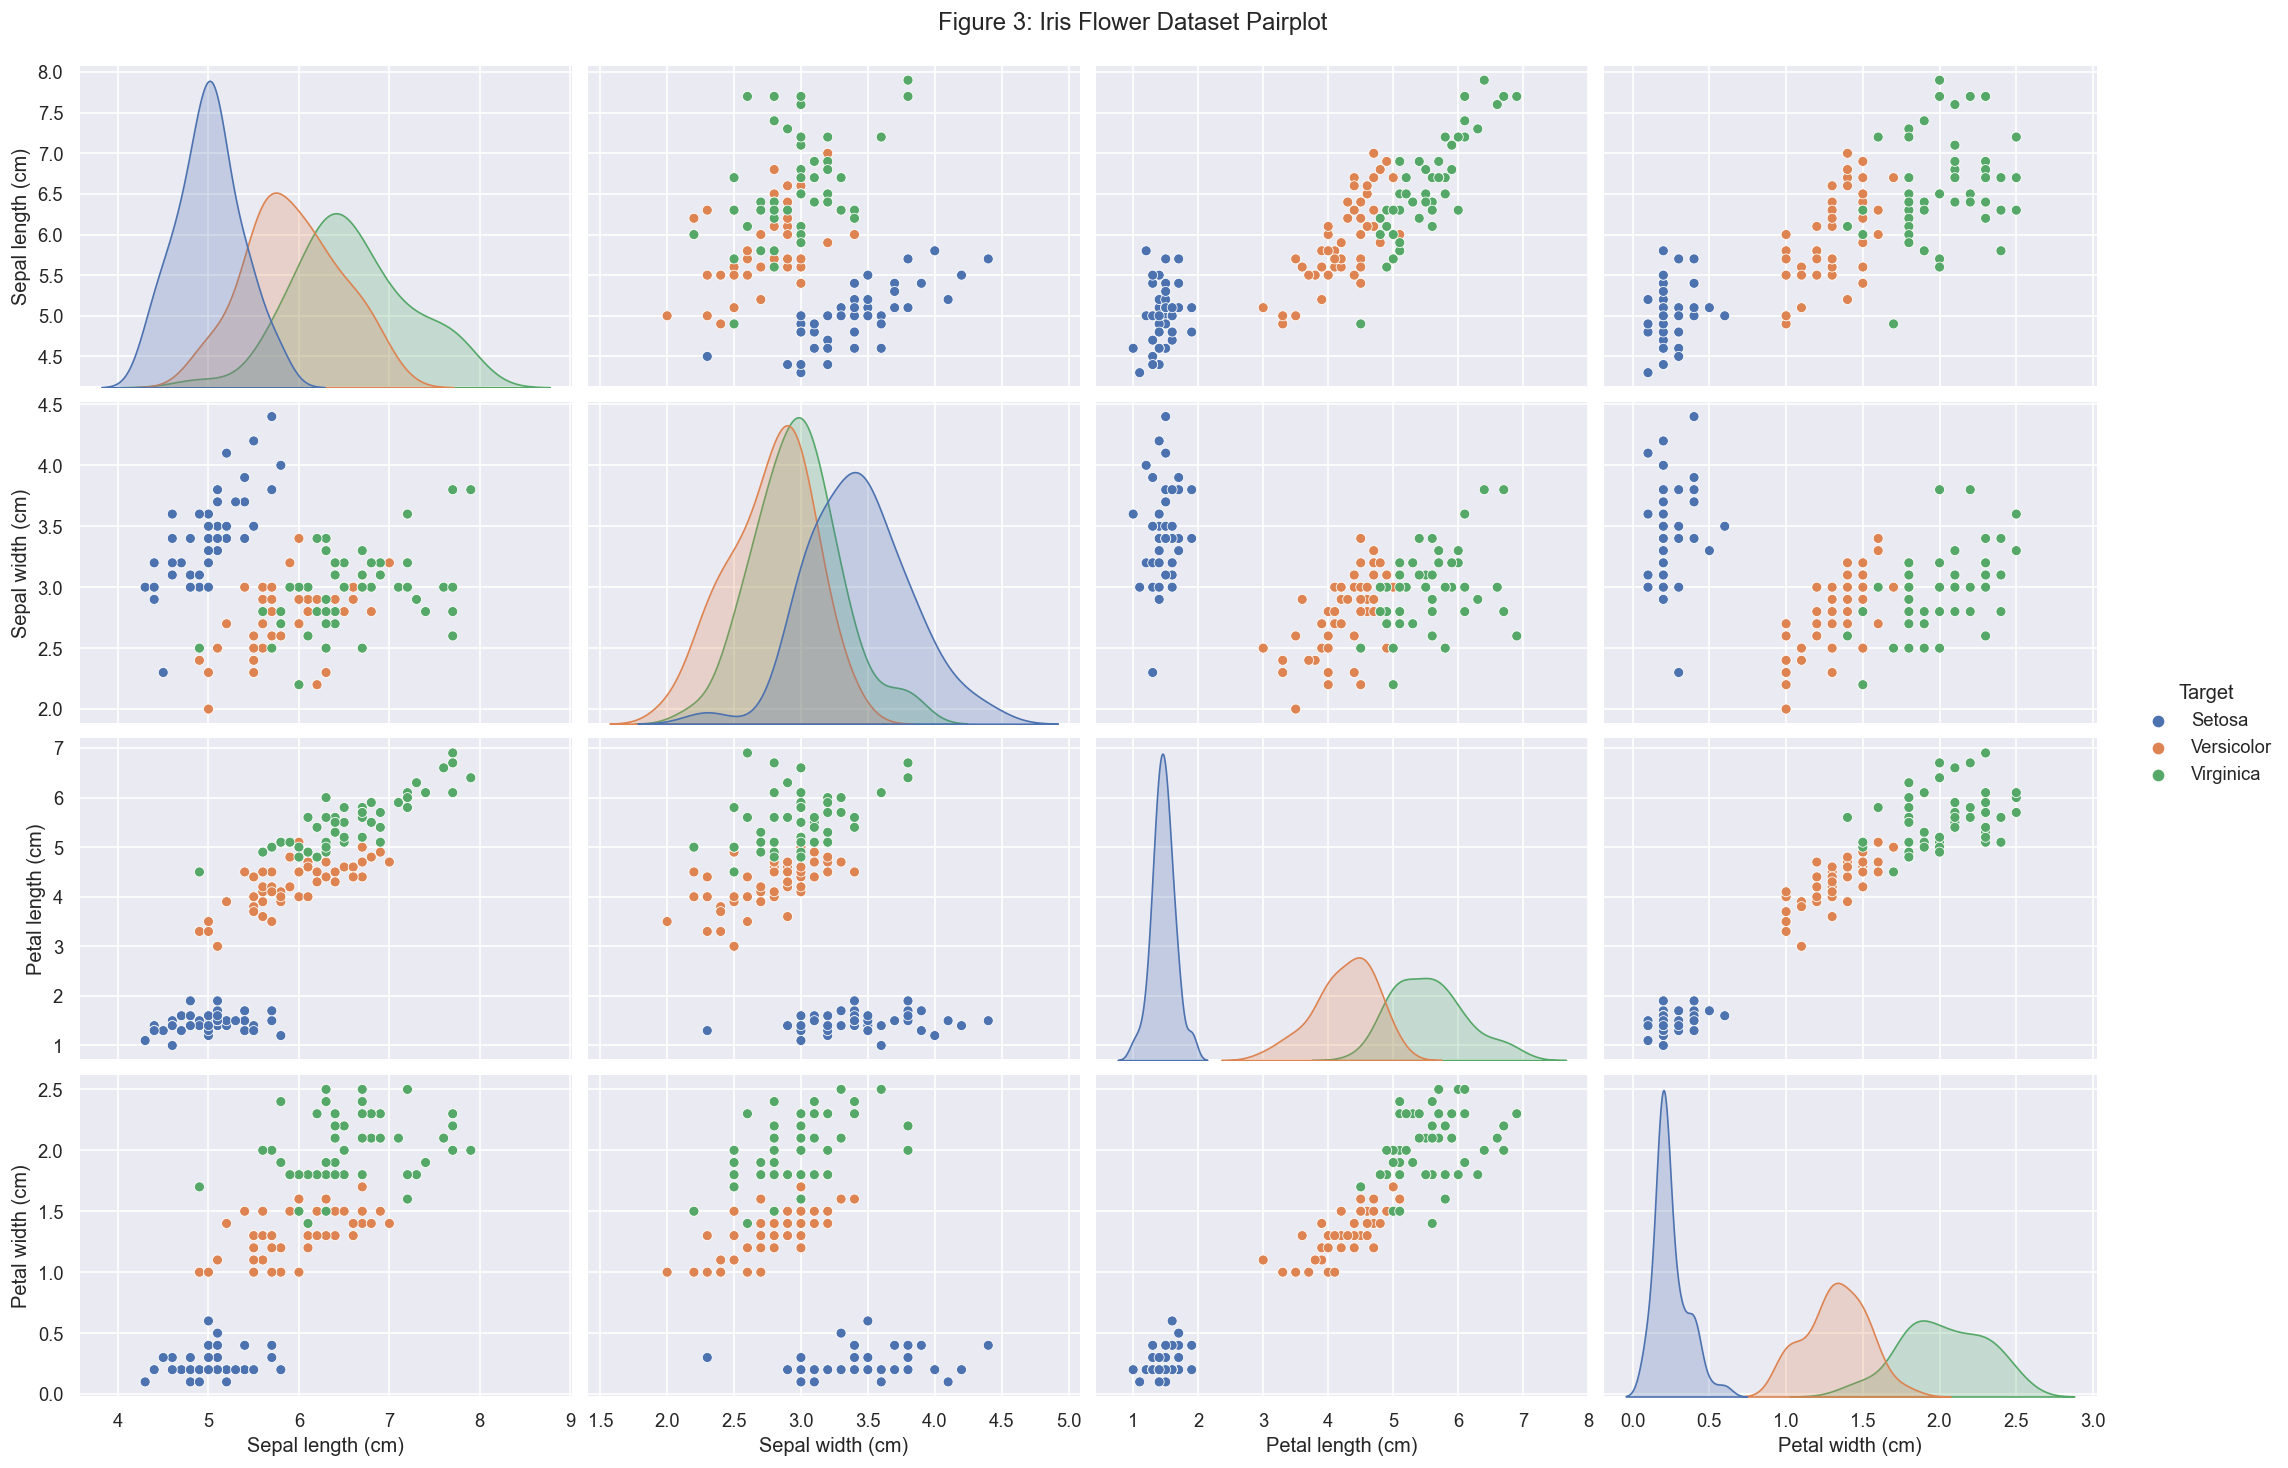

In [7]:
sns.pairplot(iris_vis, hue="Target", height=3, aspect = 1.5)
plt.suptitle("Figure 3: Iris Flower Dataset Pairplot", y=1.02)
plt.show()

In [8]:
# reduce the data for example
X_AX_LABEL = "Petal length (cm)"
Y_AX_LABEL = "Petal width (cm)"
REMOVE = "Virginica"

iris_reduced = iris_vis[[X_AX_LABEL, Y_AX_LABEL, "Target"]]
iris_reduced = iris_reduced[iris_reduced.Target != REMOVE]

# get the names of the flowers
flowers = list(iris_reduced.Target.unique())
title4 = "Figure 4: "+X_AX_LABEL+" and "+Y_AX_LABEL+" of \n"+flowers[0]+" and "+flowers[1]+" flowers"

def reduced_plot(X, x_ax_label, y_ax_label, title=None):
    # make scatterplot
    g = sns.scatterplot(data=X, x = x_ax_label, y = y_ax_label, 
                        hue="Target", style = "Target")
    
    # set the title
    if title:
        plt.title(title)
    
    # remove the legend title
    g.axes.get_legend().set_title(False)

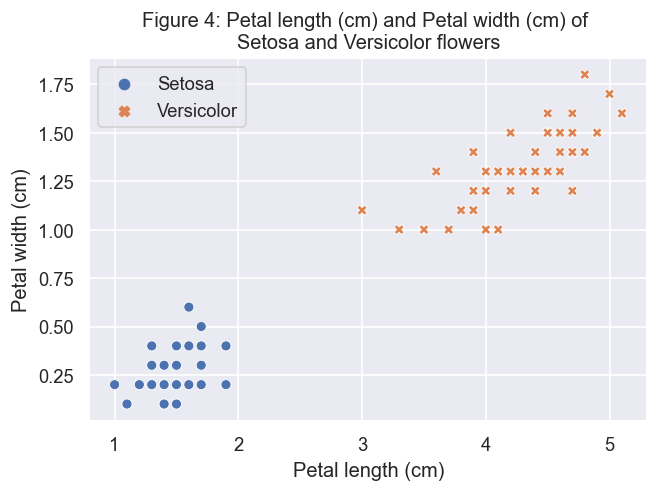

In [9]:
reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL, title4)
plt.show()

In [10]:
# Altered https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
from sklearn.svm import SVC
x0 = np.linspace(0, 5.5, 200)
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

X = iris_reduced[[X_AX_LABEL, Y_AX_LABEL]].values
y = le.transform(iris_reduced[["Target"]].values.ravel())

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)
w = svm_clf.coef_[0]
b = svm_clf.intercept_[0]

# At the decision boundary, w0*x0 + w1*x1 + b = 0
# => x1 = -w0/w1 * x0 - b/w1
x0 = np.linspace(0, 5.5, 200)
pred_1 = -w[0]/w[1] * x0 - b/w[1]

title5 = "Figure 5: Potential Decision Boundaries"

def example_lines(X, x_ax_label, y_ax_label, title, pred_lines, axes_limit = [0, 5.5, 0, 2]):
    reduced_plot(X, x_ax_label, y_ax_label, title)
    
    line_styles=["g-", "m-", "r-"]
    for i, pred_line in enumerate(pred_lines):
        plt.plot(x0, pred_line, line_styles[i], linewidth=2)
        
    plt.axis(axes_limit)
    
    plt.show()

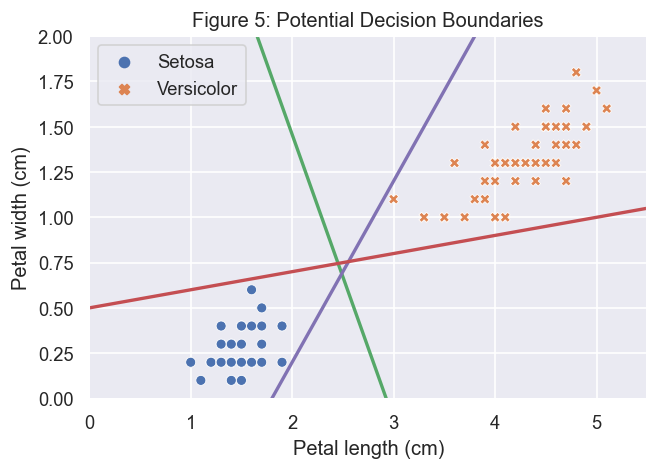

In [11]:
example_lines(iris_reduced, X_AX_LABEL, Y_AX_LABEL, title5,
              [pred_1, pred_2, pred_3])

In [12]:
# Altered https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def svc_decision_boundary(clf, xmin=0, xmax=5.5, highlight=True, axes_limit = [0, 5.5, 0, 2]):
    w = clf.coef_[0]
    b = clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = clf.support_vectors_
    if highlight:
        g = sns.scatterplot(x = svs[:, 0], y = svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "g-", linewidth=2)
    plt.plot(x0, gutter_up, "r--", linewidth=2)
    plt.plot(x0, gutter_down, "r--", linewidth=2)
    
    plt.axis(axes_limit)

# SVM Classifier model
svm_clf = SVC(kernel="linear", 
              C=float("inf") # Inf is for demo purposes (dont use in practice!)
             )
svm_clf.fit(X, y)
    
title6 = "Figure 6: Support Vector Hyperplane and Margin"

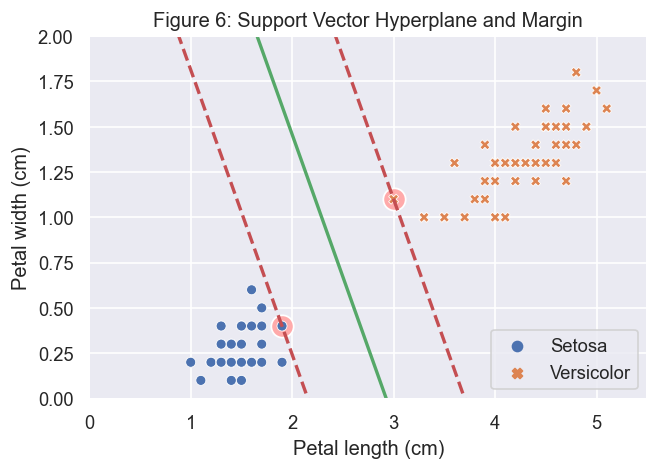

In [13]:
svc_decision_boundary(svm_clf)
reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL, title6)
plt.show()

__Notes__
- The middle thick line is a <span style="color:green">hyperplane</span> and the dashed outer lines are the edges of the <span style="color:red">margin</span>.
- The circled points are the class examples that fall on the margin. These will later be termed _support vectors_.

# 1.3. What is a Hyperplane? <a id='hyperplane'></a>
In $p$-dimensional space, a hyperplane is a flat affine subspace of dimension $p-1$.

**Examples**
- *Two-dimensions*: A flat one-dimensional line
- *Three-dimensions*: A three-dimensional subspace
- *P-dimensions*: A P-dimensional subspace

__Notes__
- affine just means _"does not need to pass through the origin"_

- Figure Examples
    - Two-dimensions: Figures 5 & 6
    - Three-dimension: Figure 7
    - P-dimensions: ...you'll have to use your imagination.

- If you want to interact with the 3D plot use `%matplotlib notebook`

__TODO__
- Make the below function more interactive and add a title

In [14]:
# Three Dimension
def three_dim():
    X = iris.data.values[:, :3]  # we only take the first three features.
    Y = iris.target

    # make it binary classification problem
    X = X[np.logical_or(Y==0,Y==1)]
    Y = Y[np.logical_or(Y==0,Y==1)]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]

    ax.set_xlabel(iris_df.columns[0])
    ax.set_ylabel(iris_df.columns[1])
    ax.set_zlabel(iris_df.columns[2])

    ax.scatter(x, y, z)

    # SVM
    model = SVC(kernel='linear')
    clf = model.fit(X, Y)

    # The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
    # Solve for w3 (z)
    z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

    xm, xM = X[:,0].min(), X[:, 0].max()
    ym, yM = X[:,1].min(), X[:, 1].max()

    number_of_squares = 10
    x = np.linspace(xm, xM, number_of_squares)
    y = np.linspace(ym, yM, number_of_squares)
    x, y =np.meshgrid(x, y)
    ax.plot_surface(x, y, z(x,y), alpha=0.5)
    ax.view_init(elev=23., azim=168.)

    plt.show()

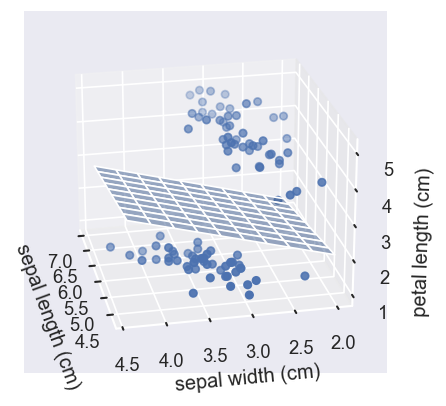

In [15]:
three_dim()

In more detail<sup>1</sup>:

*Two-dimensions*: $\beta_0 + \beta_1X_1 + \beta_2X_2 = 0$

*Three-dimensions*: $\beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 = 0$

*P-dimensions*: $\beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p = 0$

<br />

If $X = (X_1, ..., X_p)^T$ satisfies above, then it is a point on the hyperplane.

<br />

If $\beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p > 0$, it lies on one side of the hyperplane,

so if, $\beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p < 0$, its on the other side. 

__Notes__
- In-other-words, $p$-dimensional space is dividided into two halves.

__TODO__
- link this to where you see W used as weights (use python machine learning book)

### Classifying data
We aim to classify an $n \times p$ matrix of $n$ observations in $p$ dimensional space, with these observations falling into two classes $y_1,...,y_n \in \{-1,1\}$.

If we were to perfectly separate the classes the hyperplane would have the property that

$\beta_0 + \beta_1X_{i1} + \beta_2X_{i2} + ... + \beta_pX_{ip} > 0 \quad \text{if} \ y_i = 1$,

$\beta_0 + \beta_1X_{i1} + \beta_2X_{i2} + ... + \beta_pX_{ip} < 0 \quad \text{if} \ y_i = -1$.

<br />

For a new test observations $x^*$, we would look at the sign of:

$$f(x^*) = \beta_0 + \beta_1x_1^* + \beta_2x_2^* + ... + \beta_px_p^*.$$

We would assign it to class 1 if $f(x^*)$ is positive and class -1 if negative.

Furthermore, we could use the magnitude of $f(x^*)$ to indicate how far the point lies from the hyperplane.

# 1.4. Maximal Margin Classifier <a id='MMC'></a>
We need a reasonable way of constucting a hyperplane, out of the possible choices.

Maximal margin hyperplanes look at getting the hyperplane that is the furthest from the training observations - we compute the perpendicular distance from each training observation to a given separating hyperplane. 

The maximal margin hyperplane is the separating hyperplane for which the margin is largest.

We hope the classifier with a large margin on the training data will generalise well to unseen test observations.

__TODO__
- Tidy the code below
- add references where needed (probs intro to stats learning)

Another way of defining our hyperplane is:

$$\mathbf{w}^T\mathbf{x} + b = 0.$$

Our margins, where our labels $y \in \{-1,1\}$, are then

$$\mathbf{w}^T\mathbf{x} + b \geq 0 \text{ for } y_i +1$$

$$\mathbf{w}^T\mathbf{x} + b < 0 \text{ for } y_i -1$$

__Notes__

- $\mathbf{w}$ is a weight vector
- $\mathbf{x}$ is an input vector
- $b$ is our bias

- Another way is:
> $\mathbf{w} \cdot \mathbf{x}_i+b=0$.

In [16]:
%matplotlib inline
def plot_svc_margin(clf, xmin=0, xmax=5.5, highlight=False, highlight_line=False, margin_line=False, axes_limit= [0, 5.5, 0, 2], ax = None):
    w = clf.coef_[0]
    b = clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = clf.support_vectors_
    
    with sns.axes_style("dark"):
        if ax:
            plt.sca(ax)
        else:
            fig = plt.figure(figsize = (8,6))
        plt.fill_between(x0, gutter_down, facecolors='white')
        plt.fill_between(x0, gutter_up, xmax, facecolors='white')
        if highlight:
            g = sns.scatterplot(x = svs[:, 0], y = svs[:, 1], s=180, facecolors='#FFAAAA')
        if margin:
            plt.plot(x0, decision_boundary, "g-", linewidth=2, alpha=0.3)
        else:
            plt.plot(x0, decision_boundary, "g-", linewidth=2)
        plt.plot(x0, gutter_up, "r--", linewidth=2)
        plt.plot(x0, gutter_down, "r--", linewidth=2)
        
        # I've been a bit lazy here and not drawn the lines properly
        
        if highlight_line or margin_line:
            plt.arrow(svs[0, 0],svs[0, 1], 0.7, 0.125, fc='k', ec='k', linewidth=1, length_includes_head=True)
            plt.arrow(svs[1, 0],svs[1, 1], -0.7, -0.125, fc='k', ec='k', linewidth=1, length_includes_head=True)
        
        if highlight_line:
            plt.text(svs[0, 0],svs[0, 1]+0.1, r'$ x_2 $')
            plt.text(svs[1, 0],svs[1, 1]+0.1, r'$ x_1 $')
        
        if margin_line:
            plt.arrow(2.1, 0.05, 1.4, 0.25, fc='y', ec='y', linewidth=1, linestyle=':',length_includes_head=True)
            plt.text(2.55, 0.22, r'$ \frac{2}{||w||} $', fontsize=15, rotation=20)
            plt.text(svs[0, 0]-0.04,svs[0, 1]+0.04, r'$ w^Tx_2 + b = -1 $', fontsize=8, rotation=18)
            plt.text(svs[1, 0]-0.7,svs[1, 1]-0.08, r'$ w^Tx_1 + b = 1 $', fontsize=8, rotation=18)
        
    plt.axis(axes_limit)
        
title8 = "Figure 8"

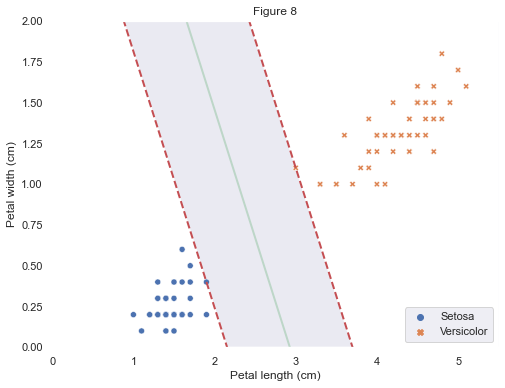

In [17]:
plot_svc_margin(svm_clf)
reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL, title8)
plt.show()

We can see below there are two equidistant points from the maximal margin hyperplane, lying on the dashed lines. These observations are called *Support Vectors*.

We can call these two points, $x_1$ and $x_2$ as below:

$$\mathbf{w}^Tx_1 + b = 1,$$

$$\mathbf{w}^Tx_2 + b = -1.$$

In [18]:
title9 = "Figure 9"

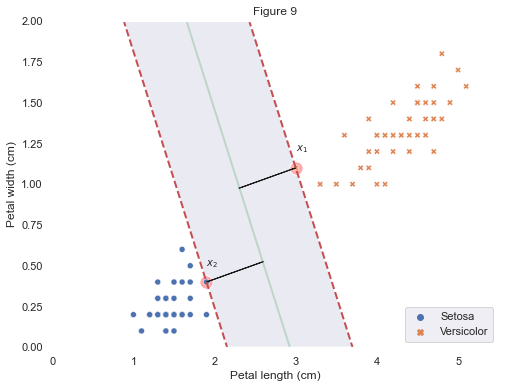

In [19]:
plot_svc_margin(svm_clf, highlight=True, highlight_line=True)
reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL, title9)
plt.show()

If we move our support vectors our hyperplane will too.

This is because the maximal margin hyperplane only depends on these support vectors. 

Other data points could be moved without the hyperplane moving.

__Notes__
- Below is more detail why this is the case.

In [20]:
# get a list of support vector indexes
S_i = list(svm_clf.support_)

X = iris_reduced.drop(S_i)[[X_AX_LABEL, Y_AX_LABEL]].values
y = le.transform(iris_reduced.drop(S_i)[["Target"]].values.ravel())

svm_clf2 = SVC(kernel="linear", 
              C=float("inf") # Inf is for demo purposes (dont use in practice!)
             )
svm_clf2.fit(X, y)

SVC(C=inf, kernel='linear')

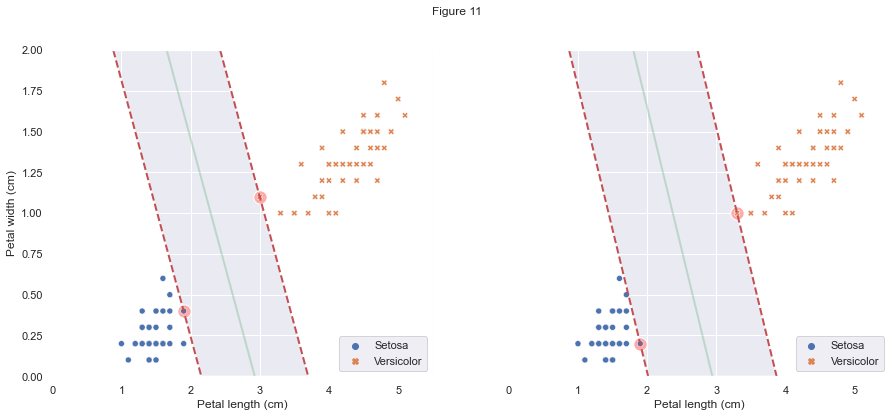

In [21]:
fig, ax = plt.subplots(1,2, figsize = (15,6), sharey=True)
ax = ax.flatten()
plot_svc_margin(svm_clf, highlight=True, ax=ax[0])
reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL)
plot_svc_margin(svm_clf2, highlight=True, ax=ax[1])
reduced_plot(iris_reduced.drop(S_i), X_AX_LABEL, Y_AX_LABEL)
plt.suptitle('Figure 11')
plt.show()

In [22]:
title10 = "Figure 10"

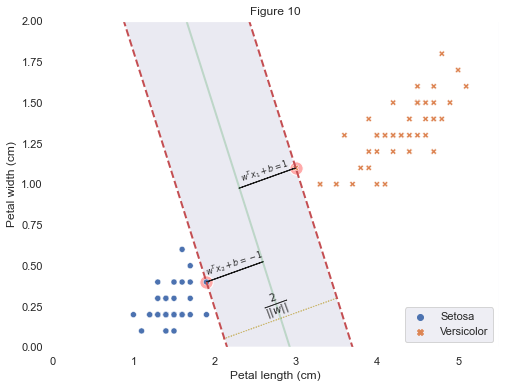

In [23]:
plot_svc_margin(svm_clf, highlight=True, margin_line=True)
reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL, title10)
plt.show()

We want to maximise the distance between the margin lines, on which the points lie<sup>4</sup>.

$$x_1-x_2$$

<br />
$$
\frac{\phantom{\quad}\mathbf{w}^Tx_1 + b = 1\\ - \mathbf{w}^Tx_2 + b = -1 \\}{\\ \mathbf{w}^T(x_1 - x_2) = 2}
$$

<br />
$$
\frac{\mathbf{w}^T}{||\mathbf{w}||}(x_1 - x_2) = \frac{2}{||\mathbf{w}||}
$$

__Notes__

1. we want the distance between $x_1$ and $x_2$
2. our $b$ cancels out and we end up with equation 3
3. we want to remove $\mathbf{w}^T$
4. we do this with norm of $\mathbf{w}^T$. However we cannot remove $||\mathbf{w}||$, so we are left to maximise $\frac{2}{||\mathbf{w}||}$.

- $||\mathbf{w}||$ is the Euclidean norm of $\mathbf{w}$

$\text{max}\frac{2}{||\mathbf{w}||}$, while classifying everything correctly, $y_i(\mathbf{w}^T\mathbf{x}_i+b) \geq 1 \quad \forall_i$.

As our two margin lines are parallel and no training points fall between them, we can find the pair of hyperplanes which gives the maximum margin by minimizing $||\mathbf{w}||^2$. So now we have<sup>5</sup>:

${\text{min} \atop \mathbf{w}, b}\frac{1}{2}||\mathbf{w}||^2 \quad \text{s.t.} \quad y_i(\mathbf{w}^T\mathbf{x}_i+b) \geq 1 \quad \forall_i$,

which is easier because this is a _convex quadratic optimisation problem_ which is efficiently solvable using quadratic programming algorithms. 

__Notes__

- $\frac{1}{2}$ is added for convience.

We will quickly switch to a _Lagrangian_ formulation of the problem so we introduce Lagrange multipliers, $\alpha_i, i = 1, \ldots , l$, which are positive $\alpha_i \geq 1$:

$L_P \equiv \frac{1}{2}||\mathbf{w}||^2 - \sum^l_{i=1} \alpha_iy_i(\mathbf{w}^T\mathbf{x}_i+b) + \sum^l_{i=1} \alpha_i$.

We could minimise the above or maximise the following _Wolfe dual_<sup>7</sup> problem:

$L_D = \sum_i\alpha_i - \frac{1}{2}\sum_{i,j}\alpha_i\alpha_jy_iy_j\mathbf{x}_i\cdot \mathbf{x}_j \quad \text{s.t.} \quad \sum_i\alpha_iy_i = 0$.

This has a solution:

$w = \sum^{N_S}_{i=1}\alpha_iy_i\mathbf{x}_i$,

where $N_S$ is the number of support vectors<sup>6</sup>.

__Notes__
- Using the duel problem we no longer have to worry about $\mathbf{w}$ and $b$ as long as $\alpha_i \geq 1$.
- There is a Lagrange multiplier $\alpha_i$ for every training point. Points for which $\alpha_i > 0$ are called "support vectors", and lie on one of the margins, with all other training points having $\alpha_i = 0$.
- Notice this means we only need to focus on those with $\alpha_i > 0$.
- For more reading on quadratic programming for support vector machines, I recommend you read:
    - Burges, C. J. (1998). A tutorial on support vector machines for pattern recognition. Data mining and knowledge discovery, 2(2), 121-167.

## Limitations

Maximal Margin Classifiers are sensitive to outliers. In figure X, we can see that the reliance on a small number of observations means there is now a small margin. We want to be confident that a distance from the hyperlane is a measure of our confidence in its classificaion, and that we have no overfit to our training data.

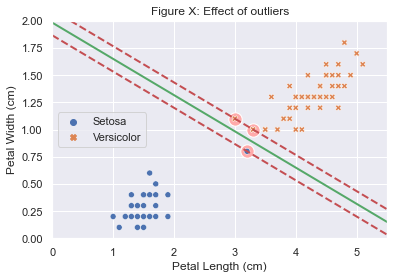

In [28]:
# adapted from https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def outlier_margin():
    X = iris_reduced[["Petal length (cm)", "Petal width (cm)"]].values
    y = le.transform(iris_reduced[["Target"]].values.ravel())
    X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
    y_outliers = np.array([0, 0])
    Xo = np.concatenate([X, X_outliers[1:]], axis=0)
    yo = np.concatenate([y, y_outliers[1:]], axis=0)

    svm_clf = SVC(kernel="linear", C=float("inf"))
    svm_clf.fit(Xo, yo)

    svc_decision_boundary(svm_clf)
    g = sns.scatterplot(x = Xo[:,0], y = Xo[:,1], hue=yo, style = yo)
    leg = g.axes.get_legend()
    new_labels = ['Setosa', 'Versicolor']
    for t, l in zip(leg.texts, new_labels): t.set_text(l)
    plt.axis([0, 5.5, 0, 2])
    plt.title("Figure X: Effect of outliers")
    plt.xlabel("Petal Length (cm)")
    plt.ylabel("Petal Width (cm)")
    
outlier_margin()
plt.show()

In other cases, no exact linear separating hyperplane exists. Therefore we may want to use a hyperplane that *almost* separates the two classes, allowing some errors, using a *soft margin* (Support Vector Classifier).

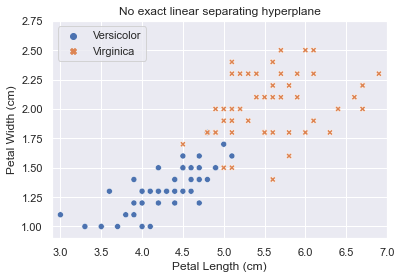

In [25]:
def soft_margin(title, hyperplane=False):
    virgin_versi = iris_vis[["Petal length (cm)", "Petal width (cm)", "Target"]]
    virgin_versi = virgin_versi[virgin_versi.Target != "Setosa"]

    X = virgin_versi[["Petal length (cm)", "Petal width (cm)"]].values
    y = virgin_versi[["Target"]].replace({'Versicolor':0, 'Virginica':1}).values.ravel()
    
    if hyperplane:
        svm_clf = SVC(kernel="linear", C=100)
        svm_clf.fit(X, y)

        svc_decision_boundary(svm_clf, 2.9, 7)
    labels = virgin_versi[["Target"]].values.ravel()
    sns.scatterplot(x = X[:,0], y = X[:,1], hue=labels, style = labels)
    plt.axis([2.9, 7, 0.9, 2.75])
    plt.title(title)
    plt.xlabel("Petal Length (cm)")
    plt.ylabel("Petal Width (cm)")
    
soft_margin("No exact linear separating hyperplane")
plt.show()

Furthermore, if we have a large number of features, this approach often leads to overfitting.

In [26]:
# [EXAMPLE CODE]

# Associated Exercises

Now might be a good time to try exercises X-X.

# References
1. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112, p. 18). New York: springer.
2. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
3. Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. Annals of eugenics, 7(2), 179-188.
4. [youtube vid]
5. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.
6. Burges, C. J. (1998). A tutorial on support vector machines for pattern recognition. Data mining and knowledge discovery, 2(2), 121-167.
7. Fletcher, R. Practical Methods of Optimization. John Wiley and Sons, Inc., 2nd edition, 1987

In [27]:
!jupyter nbconvert 1_Maximal_Margin_Classifiers.ipynb \
    --to slides \
    --output-dir . \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True \
    --SlidesExporter.reveal_scroll=True

[NbConvertApp] Converting notebook 1_Maximal_Margin_Classifiers.ipynb to slides
[NbConvertApp] Writing 2875320 bytes to 1_Maximal_Margin_Classifiers.slides.html
